In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


### Load Data
load data except 219 V columns redundant (by correlation analysis)

In [2]:
BUILD95=True
BUILD96=True

import numpy as np, pandas as pd, os, gc
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

#column with strings
str_type= ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

str_type += ['id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-30', 
            'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']

#first 53 columns
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

#V columns to load decided by correlation EDA

v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]

#v += [96, 98, 99, 104] #relates to groups, no NAN 
v += [107, 108, 111, 115, 117, 120, 121, 123] # maybe group, no NAN
v += [124, 127, 129, 130, 136] # relates to groups, no NAN

#lots of NAN below
v += [138, 139, 142, 147, 156, 162] #b1
v += [165, 160, 166] #b1
v += [178, 176, 173, 182] #b2
v += [187, 203, 205, 207, 215] #b2
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] #b2
v += [218, 223, 224, 226, 228, 229, 235] #b3
v += [240, 258, 257, 253, 252, 260, 261] #b3
v += [264, 266, 267, 274, 277] #b3
v += [220, 221, 234, 238, 250, 271] #b3

v += [294, 284, 285, 286, 291, 297] # relates to grous, no NAN
v += [303, 305, 307, 309, 310, 320] # relates to groups, no NAN
v += [281, 283, 289, 296, 301, 314] # relates to groups, no NAN
#v += [332, 325, 335, 338] # b4 lots NAN

cols += ['V'+str(x) for x in v]
dtypes={}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]+\
    ['id-0'+str(x) for x in range(1,10)]+['id-'+str(x) for x in range(10,34)]:
        dtypes[c] = 'float32'
for c in str_type: dtypes[c] = 'category'
    
    

In [3]:
%%time
#load train
X_train=pd.read_csv('../input/ieee-fraud-detection/train_transaction.csv',index_col='TransactionID',dtype=dtypes,usecols=cols+['isFraud'])
train_id = pd.read_csv('../input/ieee-fraud-detection/train_identity.csv',index_col='TransactionID',dtype=dtypes)
X_train=X_train.merge(train_id,how='left',left_index=True,right_index=True)
#load test
X_test=pd.read_csv('../input/ieee-fraud-detection/test_transaction.csv',index_col='TransactionID',dtype=dtypes,usecols=cols)
test_id=pd.read_csv('../input/ieee-fraud-detection/test_identity.csv',index_col='TransactionID',dtype=dtypes)
fix={o:n for o,n in zip(test_id.columns, train_id.columns)}
test_id.rename(columns=fix,inplace=True)
X_test=X_test.merge(test_id,how='left',left_index=True,right_index=True)

#target
y_train=X_train['isFraud'].copy()
del train_id, test_id, X_train['isFraud']; x=gc.collect()
#print status
print('Train shape',X_train.shape,'test shape',X_test.shape)

Train shape (590540, 213) test shape (506691, 213)
CPU times: user 37.6 s, sys: 2.02 s, total: 39.6 s
Wall time: 50.3 s


### Normalize D Columns
The D Columns are "time delta" from some point in the past.
We will transform the D columns into their point in the past.
This will stop the D columns from increasing with time. The formula is D15n=Transaction_Day-D15 and TransactionDT/(24*60*60). Afterward we multiple this number by negative one.

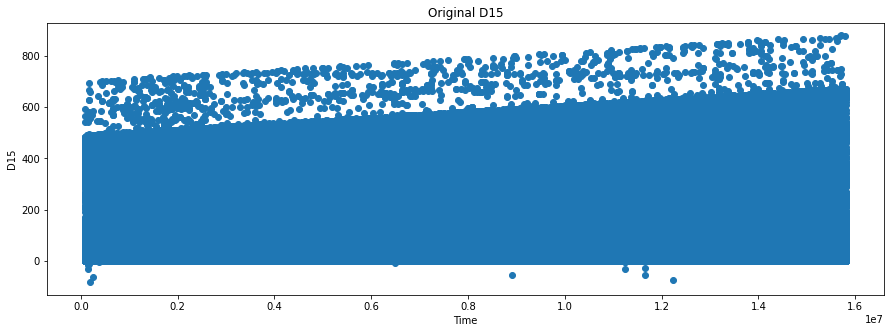

In [4]:
#plot original D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Original D15')
plt.xlabel('Time')
plt.ylabel('D15')
plt.show()

In [5]:
#normalize D columns
for i in range(1,16):
    if i in [1,2,3,5,9]:continue
    X_train['D'+str(i)]=X_train['D'+str(i)]-X_train.TransactionDT/np.float32(24*60*60) 
    X_test['D'+str(i)]=X_test['D'+str(i)]-X_test.TransactionDT/np.float32(24*60*60)

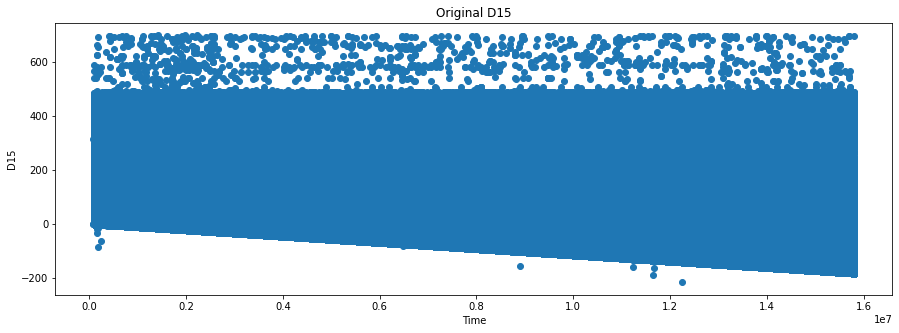

In [6]:
#plot transformed D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Original D15')
plt.xlabel('Time')
plt.ylabel('D15')
plt.show()

In [7]:
%%time
#label encode and memory reduce
for i,f in enumerate(X_train.columns):
    #factorize categorical variables
    if (np.str(X_train[f].dtype)=='category')|(X_train[f].dtype=='object'):
        df_comb=pd.concat([X_train[f],X_test[f]],axis=0)
        df_comb,_=df_comb.factorize(sort=True)
        if df_comb.max()>32000:print(f,'needs int32')
        X_train[f]=df_comb[:len(X_train)].astype('int16')
        X_test[f]=df_comb[len(X_train):].astype('int16')
    #shift all numerics positive. set NaN to -1
    elif f not in ['TransactionAmt','TransactionDT']:
        mn=np.min((X_train[f].min(),X_test[f].min()))
        X_train[f]-= np.float32(mn)
        X_test[f]-= np.float32(mn)
        X_train[f].fillna(-1,inplace=True)
        X_test[f].fillna(-1,inplace=True)

CPU times: user 3.28 s, sys: 42.6 ms, total: 3.32 s
Wall time: 3.32 s


### Encoding Functions
1. encode_FE frequency encoding
2. encode_LE label encoding for categorical features
3. encode_AG make aggregated features
4. encode_CB combines two columns
5. encode_AG2 make aggregated features: how many unique values of one feature is within a group

In [8]:
#frequency encode together
def encode_FE(df1,df2,cols):
    for col in cols: 
        df=pd.concat([df1[col],df2[col]])
        vc=df.value_counts(dropna=True,normalize=True).to_dict()
        vc[-1]=-1
        nm=col+'_FE'
        df1[nm]=df1[col].map(vc)
        df1[nm]=df1[nm].astype('float32')
        df2[nm]=df2[col].map(vc)
        df2[nm]=df2[nm].astype('float32')
        print(nm,', ',end='')
    
#label encode
def encode_LE(col,train=X_train, test=X_test, verbose=True):
    df_comb=pd.concat([train[col],test[col]],axis=0)
    df_comb,_=df_comb.factorize(sort=True)
    nm=col
    if df_comb.max()>32000:
        train[nm]=df_comb[:len(train)].astype('int32')
        test[nm]=df_comb[len(train):].astype('int32')
    else:
        train[nm]=df_comb[:len(train)].astype('int16')
        test[nm]=df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')

#group aggregation mean and std
def encode_AG(main_columns,uids,aggregations=['mean'],train_df=X_train,test_df=X_test,fillna=True, usena=False):
    #aggregation of main with uid for given statistics
    for main_column in main_columns:
        for col in uids:
            for agg_type in aggregations:
                new_col_name=main_column+'_'+col+'_'+agg_type
                temp_df=pd.concat([train_df[[col,main_column]],test_df[[col,main_column]]])
                if usena:temp_df.loc[temp_df[main_column]==-1,main_column]=np.nan
                temp_df=temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(columns={agg_type:new_col_name})
                temp_df.index=list(temp_df[col])
                temp_df=temp_df[new_col_name].to_dict()
                
                train_df[new_col_name]=train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]=test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                print("'"+new_col_name+"'",', ',end='')
                
#combine features
def encode_CB(col1,col2,df1=X_train,df2=X_test):
    nm=col1+'_'+col2
    df1[nm]=df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm]=df2[col1].astype(str)+'_'+df1[col2].astype(str)
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')

#group aggregation nunique
def encode_AG2(main_columns, uids,train_df=X_train, test_df=X_test):
    for main_column in main_columns:
        for col in uids:
            comb=pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp=comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct']=train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct']=test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')

### Feature Engineering
create a new feature, add it to the model, evaluate AUC:

increse--> keep, o/w--> discard

In [19]:
%%time
#transaction amt cents
X_train['cents']=(X_train['TransactionAmt']-np.floor(X_train['TransactionAmt'])).astype('float32')
X_test['cents'] = (X_test['TransactionAmt']-np.floor(X_test['TransactionAmt'])).astype('float32')
print('cents, ',end='')
#frquency encode: addr1,card1,card2,card3,P_emaildomain
encode_FE(X_train,X_test,['addr1','card1','card2','card3','P_emaildomain'])
#combine columns card1+addr1, card1+addr1+P_emaildomain
encode_CB('card1','addr1')
encode_CB('card1_addr1','P_emaildomain')
#frequency encode
encode_FE(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])
#group aggregate
encode_AG(['TransactionAmt','D9','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],['mean','std'],usena=True)

cents, addr1_FE , card1_FE , card2_FE , card3_FE , P_emaildomain_FE , card1_addr1 , card1_addr1_P_emaildomain , card1_addr1_FE , card1_addr1_P_emaildomain_FE , 'TransactionAmt_card1_mean' , 'TransactionAmt_card1_std' , 'TransactionAmt_card1_addr1_mean' , 'TransactionAmt_card1_addr1_std' , 'TransactionAmt_card1_addr1_P_emaildomain_mean' , 'TransactionAmt_card1_addr1_P_emaildomain_std' , 'D9_card1_mean' , 'D9_card1_std' , 'D9_card1_addr1_mean' , 'D9_card1_addr1_std' , 'D9_card1_addr1_P_emaildomain_mean' , 'D9_card1_addr1_P_emaildomain_std' , 'D11_card1_mean' , 'D11_card1_std' , 'D11_card1_addr1_mean' , 'D11_card1_addr1_std' , 'D11_card1_addr1_P_emaildomain_mean' , 'D11_card1_addr1_P_emaildomain_std' , CPU times: user 16.3 s, sys: 2.24 s, total: 18.6 s
Wall time: 18.5 s


### Feature Selection - Time Consistency
We added 28 new features above. So we currently have 242 features.We will now check each of our 242 for "time consistency".

make 242 models being trained on the first month of the training data and using one feature.
then, predict last month of the training data.
We want both training AUC and validation AUC to be above AUC = 0.5. --> It turns out that 19 features fail this test so we will remove them. 

Additionally we will remove 7 D columns that are mostly NAN.

In [20]:
cols=list(X_train.columns)
cols.remove('TransactionDT')
for c in ['D6','D7','D8','D9','D12','D13','D14']:
    cols.remove(c)

#failed time consistency test
for c in ['C3','M5','id_08','id_33']:
    cols.remove(c)
for c in ['card4','id_07','id_14','id_21','id_30','id_32','id_34']:
    cols.remove(c)
for c in ['id_'+str(x) for x in range(22,28)]:
    cols.remove(c)

In [21]:
print('Now using the following',len(cols),'features.')
np.array(cols)

Now using the following 217 features.


array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5',
       'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8',
       'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17',
       'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41',
       'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62', 'V65', 'V67',
       'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89',
       'V91', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121',
       'V123', 'V124', 'V127', 'V129', 'V130', 'V136', 'V138', 'V139',
       'V142', 'V147', 'V156', 'V160', 'V162', 'V165', 'V166', 'V169',
       'V171', 'V173', 'V175', 'V176', 'V178', 'V180', 'V182', 'V185',
       'V187', 'V188', 'V198', 'V203', 'V205', 'V207', 'V209', 'V210',
       '

### Local Validation 
time based local validation

In [22]:
#TRAIN 75% PREDICT 25%
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

In [23]:
import xgboost as xgb
print("XGBoost version:", xgb.__version__)

if BUILD95:
    clf = xgb.XGBClassifier(
        n_estimators=2000,
        max_depth=12,
        learning_rate=0.02,
        subsample=0.8,
        colsample_bytree=0.4,
        missing=-1,
        eval_metric='auc',
        tree_method='gpu_hist'
    )
    h = clf.fit(X_train.loc[idxT,cols], y_train[idxT], 
        eval_set=[(X_train.loc[idxV,cols],y_train[idxV])],
        verbose=50, early_stopping_rounds=100)

XGBoost version: 1.4.0


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.79854
[50]	validation_0-auc:0.87355
[100]	validation_0-auc:0.88666
[150]	validation_0-auc:0.90035
[200]	validation_0-auc:0.91469
[250]	validation_0-auc:0.92046
[300]	validation_0-auc:0.92694
[350]	validation_0-auc:0.93014
[400]	validation_0-auc:0.93040
[450]	validation_0-auc:0.93071
[500]	validation_0-auc:0.93269
[550]	validation_0-auc:0.93211
[600]	validation_0-auc:0.93187
[645]	validation_0-auc:0.93178


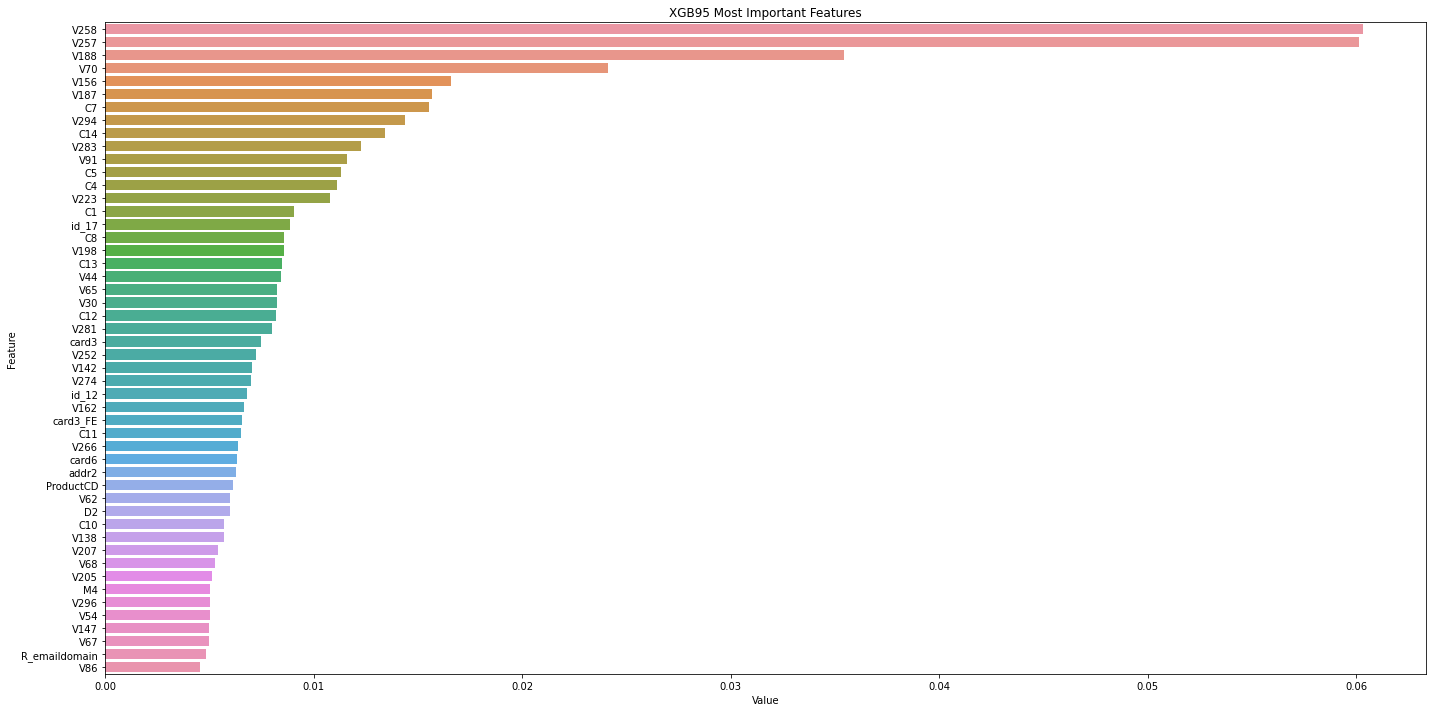

In [24]:
if BUILD95:

    feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,cols)), columns=['Value','Feature'])
    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
    plt.title('XGB95 Most Important Features')
    plt.tight_layout()
    plt.show()
    del clf, h; x=gc.collect()

### Predict test.csv
We will predict test.csv using "GroupKFold" with months as groups.12-17월 데이터 중 13-17월 훈련시켜 12월 예측(only for early_stop), 예측(test.csv)은 미래만

In [25]:
import datetime
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
X_train['DT_M'] = X_train['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_train['DT_M'] = (X_train['DT_M'].dt.year-2017)*12 + X_train['DT_M'].dt.month 

X_test['DT_M'] = X_test['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_test['DT_M'] = (X_test['DT_M'].dt.year-2017)*12 + X_test['DT_M'].dt.month 

In [26]:
if BUILD95:
    oof = np.zeros(len(X_train))
    preds = np.zeros(len(X_test))

    skf = GroupKFold(n_splits=6)
    for i, (idxT, idxV) in enumerate( skf.split(X_train, y_train, groups=X_train['DT_M']) ):
        month = X_train.iloc[idxV]['DT_M'].iloc[0]
        print('Fold',i,'withholding month',month)
        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
        clf = xgb.XGBClassifier(
            n_estimators=5000,
            max_depth=12,
            learning_rate=0.02,
            subsample=0.8,
            colsample_bytree=0.4,
            missing=-1,
            eval_metric='auc',
            # USE CPU
            #nthread=4,
            #tree_method='hist'
            # USE GPU
            tree_method='gpu_hist' 
        )        
        h = clf.fit(X_train[cols].iloc[idxT], y_train.iloc[idxT], 
                eval_set=[(X_train[cols].iloc[idxV],y_train.iloc[idxV])],
                verbose=100, early_stopping_rounds=200)
    
        oof[idxV] += clf.predict_proba(X_train[cols].iloc[idxV])[:,1]
        preds += clf.predict_proba(X_test[cols])[:,1]/skf.n_splits
        del h, clf
        x=gc.collect()
    print('#'*20)
    print ('XGB95 OOF CV=',roc_auc_score(y_train,oof))

Fold 0 withholding month 12
 rows of train = 453219 rows of holdout = 137321


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.77116
[100]	validation_0-auc:0.86314
[200]	validation_0-auc:0.87950
[300]	validation_0-auc:0.88881
[400]	validation_0-auc:0.89298
[500]	validation_0-auc:0.89095
[600]	validation_0-auc:0.89175
[700]	validation_0-auc:0.89125
[800]	validation_0-auc:0.89434
[900]	validation_0-auc:0.89388
[901]	validation_0-auc:0.89332


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Fold 1 withholding month 15
 rows of train = 488908 rows of holdout = 101632
[0]	validation_0-auc:0.82264
[100]	validation_0-auc:0.89157
[200]	validation_0-auc:0.92923
[300]	validation_0-auc:0.93320
[400]	validation_0-auc:0.94463
[500]	validation_0-auc:0.93254
[600]	validation_0-auc:0.94661
[700]	validation_0-auc:0.93429
[800]	validation_0-auc:0.94646
[848]	validation_0-auc:0.93621
Fold 2 withholding month 13
 rows of train = 497955 rows of holdout = 92585
[0]	validation_0-auc:0.82687
[100]	validation_0-auc:0.89362
[200]	validation_0-auc:0.91628
[300]	validation_0-auc:0.92764
[400]	validation_0-auc:0.93089
[500]	validation_0-auc:0.93251
[600]	validation_0-auc:0.93238
[700]	validation_0-auc:0.93301
[774]	validation_0-auc:0.93517
Fold 3 withholding month 17
 rows of train = 501214 rows of holdout = 89326
[0]	validation_0-auc:0.81496
[100]	validation_0-auc:0.90008
[200]	validation_0-auc:0.92505
[300]	validation_0-auc:0.93405
[400]	validation_0-auc:0.93634
[500]	validation_0-auc:0.93389
[6

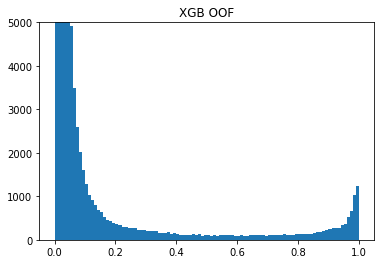

In [27]:
if BUILD95:
    plt.hist(oof,bins=100)
    plt.ylim((0,5000))
    plt.title('XGB OOF')
    plt.show()

    X_train['oof']=oof
    X_train.reset_index(inplace=True)
    X_train[['TransactionID','oof']].to_csv('oof_xgb_95.csv')
    X_train.set_index('TransactionID',drop=True,inplace=True)
    
else: X_train['oof'] = 0

### Kaggle submission file XGB_95

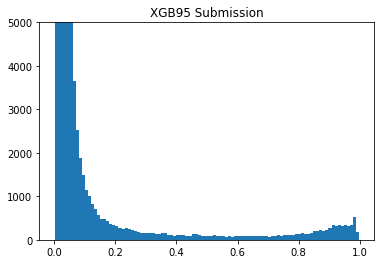

In [28]:
if BUILD95:
    sample_submission=pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv')
    sample_submission.isFraud = preds
    sample_submission.to_csv('sub_xgb_95.csv',index=False)

    plt.hist(sample_submission.isFraud,bins=100)
    plt.ylim((0,5000))
    plt.title('XGB95 Submission')
    plt.show()

### The Magic Feature -UID
create a UID which will help our model find clients (credit cards)

In [29]:
X_train['day']=X_train.TransactionDT/(24*60*60)
X_train['uid']=X_train.card1_addr1.astype(str)+'_'+np.floor(X_train.day-X_train.D1).astype(str)

X_test['day']=X_test.TransactionDT / (24*60*60)
X_test['uid']=X_test.card1_addr1.astype(str)+'_'+np.floor(X_test.day-X_test.D1).astype(str)

### Group Aggregation Features
For our model to use the new UID, we need to make lots of aggregated group features(47). Note that after aggregation, we remove UID from our model. We don't use UID directly.

In [30]:
%%time
#frequency encode uid
encode_FE(X_train,X_test,['uid'])
#aggregate
encode_AG(['TransactionAmt','D4','D9','D10','D15'],['uid'],['mean','std'],fillna=True,usena=True)
#aggregate
encode_AG(['C'+str(x) for x in range(1,15) if x!=3],['uid'],['mean'],X_train,X_test,fillna=True,usena=True)
#aggregate
encode_AG(['M'+str(x) for x in range(1,10)],['uid'],['mean'],X_train,X_test,fillna=True,usena=True)
#aggregate
encode_AG2(['P_emaildomain','dist1','DT_M','id_02','cents'],['uid'],train_df=X_train,test_df=X_test)
#aggregate
encode_AG2(['C14'],['uid'],['std'],X_train,X_test,fillna=True,usena=True)
#aggregate
encode_AG2(['C13','V314'],['uid'],train_df=X_train,test_df=X_test)
#aggregate
encode_AG2(['V127','V136','V309','V307','V320'],['uid'],train_df=X_train, test_df=X_test)

#new feature
X_train['outsider15']=(np.abs(X_train.D1-X_train.D15)>3).astype('int8')
X_test['outsider15']=(np.abs(X_test.D1-X_test.D15)>3).astype('int8')
print('outsider15')

uid_FE , 'TransactionAmt_uid_mean' , 'TransactionAmt_uid_std' , 'D4_uid_mean' , 'D4_uid_std' , 'D9_uid_mean' , 'D9_uid_std' , 'D10_uid_mean' , 'D10_uid_std' , 'D15_uid_mean' , 'D15_uid_std' , 'C1_uid_mean' , 'C2_uid_mean' , 'C4_uid_mean' , 'C5_uid_mean' , 'C6_uid_mean' , 'C7_uid_mean' , 'C8_uid_mean' , 'C9_uid_mean' , 'C10_uid_mean' , 'C11_uid_mean' , 'C12_uid_mean' , 'C13_uid_mean' , 'C14_uid_mean' , 'M1_uid_mean' , 'M2_uid_mean' , 'M3_uid_mean' , 'M4_uid_mean' , 'M5_uid_mean' , 'M6_uid_mean' , 'M7_uid_mean' , 'M8_uid_mean' , 'M9_uid_mean' , uid_P_emaildomain_ct, uid_dist1_ct, uid_DT_M_ct, uid_id_02_ct, uid_cents_ct, 

TypeError: encode_AG2() got an unexpected keyword argument 'fillna'

In [31]:
cols = list( X_train.columns )
cols.remove('TransactionDT')
for c in ['D6','D7','D8','D9','D12','D13','D14']:
    cols.remove(c)
for c in ['oof','DT_M','day','uid']:
    cols.remove(c)
    
# FAILED TIME CONSISTENCY TEST
for c in ['C3','M5','id_08','id_33']:
    cols.remove(c)
for c in ['card4','id_07','id_14','id_21','id_30','id_32','id_34']:
    cols.remove(c)
for c in ['id_'+str(x) for x in range(22,28)]:
    cols.remove(c)

In [32]:
print('now using following',len(cols),'features.')
np.array(cols)

now using following 254 features.


array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5',
       'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8',
       'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17',
       'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41',
       'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62', 'V65', 'V67',
       'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89',
       'V91', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121',
       'V123', 'V124', 'V127', 'V129', 'V130', 'V136', 'V138', 'V139',
       'V142', 'V147', 'V156', 'V160', 'V162', 'V165', 'V166', 'V169',
       'V171', 'V173', 'V175', 'V176', 'V178', 'V180', 'V182', 'V185',
       'V187', 'V188', 'V198', 'V203', 'V205', 'V207', 'V209', 'V210',
       '

### Local validation


In [33]:
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

In [34]:
if BUILD96:
    clf = xgb.XGBClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc',
        #nthread=4,
        #tree_method='hist' 
        tree_method='gpu_hist' 
    )
    h = clf.fit(X_train.loc[idxT,cols], y_train[idxT], 
        eval_set=[(X_train.loc[idxV,cols],y_train[idxV])],
        verbose=50, early_stopping_rounds=100)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.78444
[50]	validation_0-auc:0.87733
[100]	validation_0-auc:0.89607
[150]	validation_0-auc:0.91160
[200]	validation_0-auc:0.92240
[250]	validation_0-auc:0.92946
[300]	validation_0-auc:0.93383
[350]	validation_0-auc:0.93660
[400]	validation_0-auc:0.93727
[450]	validation_0-auc:0.93936
[500]	validation_0-auc:0.93886
[515]	validation_0-auc:0.93888


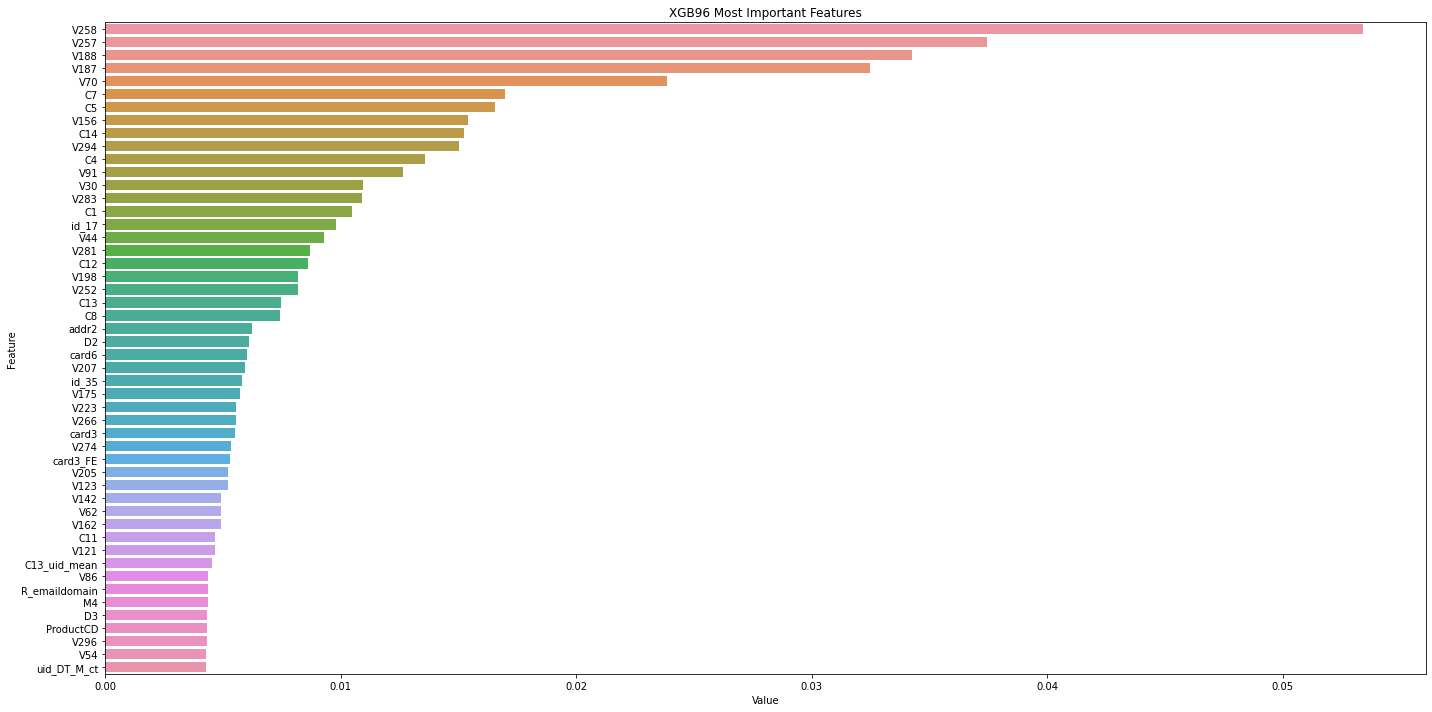

In [37]:
if BUILD96:
    
    feature_imp=pd.DataFrame(sorted(zip(clf.feature_importances_,cols)), columns=['Value','Feature'])
    plt.figure(figsize=(20,10))
    sns.barplot(x="Value",y="Feature",data=feature_imp.sort_values(by="Value",ascending=False).iloc[:50])
    plt.title('XGB96 Most Important Features')
    plt.tight_layout()
    plt.show()
    del clf, h;x=gc.collect()

### Predict test.csv

In [38]:
if BUILD96:
    oof = np.zeros(len(X_train))
    preds = np.zeros(len(X_test))

    skf = GroupKFold(n_splits=6)
    for i, (idxT, idxV) in enumerate( skf.split(X_train, y_train, groups=X_train['DT_M']) ):
        month = X_train.iloc[idxV]['DT_M'].iloc[0]
        print('Fold',i,'withholding month',month)
        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
        clf = xgb.XGBClassifier(
            n_estimators=5000,
            max_depth=12,
            learning_rate=0.02,
            subsample=0.8,
            colsample_bytree=0.4,
            missing=-1,
            eval_metric='auc',
            # USE CPU
            #nthread=4,
            #tree_method='hist'
            # USE GPU
            tree_method='gpu_hist' 
        )        
        h = clf.fit(X_train[cols].iloc[idxT], y_train.iloc[idxT], 
                eval_set=[(X_train[cols].iloc[idxV],y_train.iloc[idxV])],
                verbose=100, early_stopping_rounds=200)
    
        oof[idxV] += clf.predict_proba(X_train[cols].iloc[idxV])[:,1]
        preds += clf.predict_proba(X_test[cols])[:,1]/skf.n_splits
        del h, clf
        x=gc.collect()
    print('#'*20)
    print ('XGB96 OOF CV=',roc_auc_score(y_train,oof))

Fold 0 withholding month 12
 rows of train = 453219 rows of holdout = 137321


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.78316
[100]	validation_0-auc:0.87760
[200]	validation_0-auc:0.89438
[300]	validation_0-auc:0.90340
[400]	validation_0-auc:0.90731
[500]	validation_0-auc:0.90972
[600]	validation_0-auc:0.90942
[700]	validation_0-auc:0.90837
[800]	validation_0-auc:0.91062
[900]	validation_0-auc:0.91057
[1000]	validation_0-auc:0.91011
[1100]	validation_0-auc:0.91055
[1200]	validation_0-auc:0.90938
[1300]	validation_0-auc:0.90957
[1400]	validation_0-auc:0.91161
[1437]	validation_0-auc:0.91159


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Fold 1 withholding month 15
 rows of train = 488908 rows of holdout = 101632
[0]	validation_0-auc:0.82957
[100]	validation_0-auc:0.90290
[200]	validation_0-auc:0.92696
[300]	validation_0-auc:0.94280
[400]	validation_0-auc:0.95548
[500]	validation_0-auc:0.94324
[600]	validation_0-auc:0.94155
[700]	validation_0-auc:0.95473
[800]	validation_0-auc:0.95255
[893]	validation_0-auc:0.93982
Fold 2 withholding month 13
 rows of train = 497955 rows of holdout = 92585
[0]	validation_0-auc:0.83768
[100]	validation_0-auc:0.90423
[200]	validation_0-auc:0.93740
[300]	validation_0-auc:0.94324
[400]	validation_0-auc:0.94664
[500]	validation_0-auc:0.94868
[600]	validation_0-auc:0.94780
[700]	validation_0-auc:0.95122
[800]	validation_0-auc:0.94756
[849]	validation_0-auc:0.94765
Fold 3 withholding month 17
 rows of train = 501214 rows of holdout = 89326
[0]	validation_0-auc:0.80221
[100]	validation_0-auc:0.90271
[200]	validation_0-auc:0.92275
[300]	validation_0-auc:0.93652
[400]	validation_0-auc:0.94867
[5

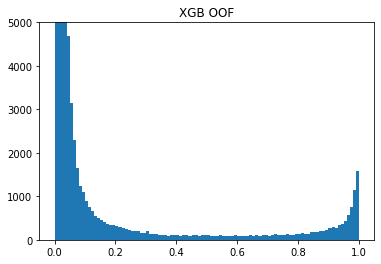

In [39]:
if BUILD96:
    plt.hist(oof,bins=100)
    plt.ylim((0,5000))
    plt.title('XGB OOF')
    plt.show()

    X_train['oof']=oof
    X_train.reset_index(inplace=True)
    X_train[['TransactionID','oof']].to_csv('oof_xgb_96.csv')
    X_train.set_index('TransactionID',drop=True,inplace=True)
    

### Kaggle submission file XGB_96

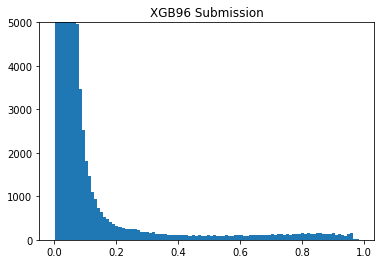

In [40]:
if BUILD96:
    sample_submission=pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv')
    sample_submission.isFraud = preds
    sample_submission.to_csv('sub_xgb_96.csv',index=False)

    plt.hist(sample_submission.isFraud,bins=100)
    plt.ylim((0,5000))
    plt.title('XGB96 Submission')
    plt.show()

### Post process file XGB_96_PP
Our post process is to replace all predictions from one client with their average prediction including the isFraud values from the train dataset.


In [ ]:
X_test['isFraud']=sample_submission.isFraud.values
X_train['isFraud']=y_train.values
comb= pd.concat([X_train[['isFraud']],X_test[['isFraud']]],axis=0)

uids=pd.read_csv('/kaggle/input/ieee-submissions-and-uids/uids_v4_no_multiuid_cleaning..csv',usecols=['TransactionID','uid']).rename({'uid':'uid2'},axis=1)
comb=comb.merge(uids,on='TransactionID',how='left')
mp=comb.groupby('uid2').isFraud.agg(['mean'])
comb.loc[comb.uid2>0,'isFraud']=comb.loc[comb.uid2>0].uid2.map(mp['mean'])

uids=pd.read_csv('/kaggle/input/ieee-submissions-and-uids/uids_v1_no_multiuid_cleaning.csv',usecols=['TransactionID','uid']).rename({'uid':'uid3'},axis=1)
comb=comb.merge(uids,on='TransactionID',how='left')
mp=comb.groupby('uid3').isFraud.agg(['mean'])
comb.loc[comb.uid3>0,'isFraud']=comb.loc[comb.uid3>0].uid3.map(mp['mean'])

sample_submission.isFraud=comb.iloc[len(X_train):].isFraud.values
sample_submission.to_csv('sub_xgb_96_pp.csv',index=False)